In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DATA_DIR = "/content/drive/MyDrive/Slake/Slake1.0"
CHECKPOINT_DIR = "/content/drive/MyDrive/MedVQA_Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

P1_PATH = os.path.join(CHECKPOINT_DIR, "clip_vqa_phase11.pt")
P2_PATH = os.path.join(CHECKPOINT_DIR, "clip_vqa_phase22.pt")

print(DATA_DIR)

/content/drive/MyDrive/Slake/Slake1.0


In [3]:
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q langdetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import clip
from PIL import Image
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from sklearn.metrics import f1_score
import numpy as np


In [5]:
# Make language detection deterministic
DetectorFactory.seed = 0

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [6]:
clip_model_name = "ViT-B/32"
clip_model, preprocess = clip.load(clip_model_name, device=device)
tokenizer = clip.tokenize

clip_model = clip_model.float()

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 91.4MiB/s]


In [7]:
# Load data
train_json = os.path.join(DATA_DIR, "train.json")
val_json   = os.path.join(DATA_DIR, "validate.json")
test_json  = os.path.join(DATA_DIR, "test.json")
images_folder = os.path.join(DATA_DIR, "imgs")

with open(train_json, 'r') as f:
    train_data = json.load(f)

with open(val_json, 'r') as f:
    val_data = json.load(f)

with open(test_json, 'r') as f:
    test_data = json.load(f)

print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))



Train: 9835
Val: 2099
Test: 2094


In [8]:
from collections import Counter
answer_counts = Counter(item['answer'] for item in train_data)

print(f"Total unique answers: {len(answer_counts)}")
print(f"Answers appearing once: {sum(1 for c in answer_counts.values() if c == 1)}")
print(f"Answers appearing <5 times: {sum(1 for c in answer_counts.values() if c < 5)}")
print(f"Answers appearing ≥10 times: {sum(1 for c in answer_counts.values() if c >= 10)}")

print("\nTop 10 most common answers:")
for ans, count in answer_counts.most_common(10):
    print(f"  {ans}: {count}")

print("\nBottom 10 rarest answers:")
for ans, count in answer_counts.most_common()[-10:]:
    print(f"  {ans}: {count}")

Total unique answers: 484
Answers appearing once: 138
Answers appearing <5 times: 273
Answers appearing ≥10 times: 135

Top 10 most common answers:
  Yes: 864
  No: 817
  包含: 334
  不包含: 330
  不是: 328
  是的: 315
  CT: 267
  肺: 264
  Lung: 253
  Chest: 220

Bottom 10 rarest answers:
  直肠上方: 1
  小肠,结肠,直肠: 1
  脑肿瘤, 脑水肿: 1
  右上部: 1
  中下部: 1
  脑水肿,脑瘤: 1
  肺,肝脏,心脏: 1
  肝脏,心脏,脾脏: 1
  左肺, 右上: 1
  肝脏,心脏,肺: 1


In [9]:
from collections import Counter

# Split by language
en_train = [item for item in train_data if item.get('q_lang') == 'en']
zh_train = [item for item in train_data if item.get('q_lang') == 'zh']

en_counts = Counter(item['answer'] for item in en_train)
zh_counts = Counter(item['answer'] for item in zh_train)

print("="*60)
print("ENGLISH vs CHINESE COMPARISON")
print("="*60)

print("\n ENGLISH:")
print(f"  Samples: {len(en_train)}")
print(f"  Unique answers: {len(en_counts)}")
print(f"  Answers ≥10 times: {sum(1 for c in en_counts.values() if c >= 10)}")
print(f"Answers appearing once: {sum(1 for c in en_counts.values() if c == 1)}")
print(f"Answers appearing >=5 times: {sum(1 for c in en_counts.values() if c >= 5)}")
print(f"Answers appearing <10 times: {sum(1 for c in en_counts.values() if c < 10)}")

print("\n CHINESE:")
print(f"  Samples: {len(zh_train)}")
print(f"  Unique answers: {len(zh_counts)}")
print(f"  Answers ≥10 times: {sum(1 for c in zh_counts.values() if c >= 10)}")
print(f"Answers appearing once: {sum(1 for c in zh_counts.values() if c == 1)}")
print(f"Answers appearing >=5 times: {sum(1 for c in zh_counts.values() if c >= 5)}")
print(f"Answers appearing <10 times: {sum(1 for c in zh_counts.values() if c < 10)}")

print("\n" + "="*60)
print("TOP 15 ENGLISH ANSWERS")
print("="*60)
for ans, count in en_counts.most_common(15):
    print(f"  {ans}: {count}")

print("\n" + "="*60)
print("TOP 15 CHINESE ANSWERS")
print("="*60)
for ans, count in zh_counts.most_common(15):
    print(f"  {ans}: {count}")




ENGLISH vs CHINESE COMPARISON

 ENGLISH:
  Samples: 4919
  Unique answers: 228
  Answers ≥10 times: 65
Answers appearing once: 60
Answers appearing >=5 times: 106
Answers appearing <10 times: 163

 CHINESE:
  Samples: 4916
  Unique answers: 268
  Answers ≥10 times: 77
Answers appearing once: 78
Answers appearing >=5 times: 116
Answers appearing <10 times: 191

TOP 15 ENGLISH ANSWERS
  Yes: 864
  No: 817
  Lung: 253
  Chest: 220
  Liver: 159
  Head: 129
  CT: 126
  Brain: 117
  2: 109
  Abdomen: 103
  MRI: 99
  X-Ray: 99
  Heart: 86
  T2: 71
  Black: 71

TOP 15 CHINESE ANSWERS
  包含: 334
  不包含: 330
  不是: 328
  是的: 315
  肺: 264
  胸腔: 186
  肝脏: 157
  横断面: 156
  没有: 148
  CT: 141
  大脑: 114
  2: 109
  头部: 101
  腹部: 100
  有: 94


In [10]:
# =========================
#  Keep top-65 answers
# =========================
TOP_K = 65
top_answers = [ans for ans, _ in en_counts.most_common(TOP_K)]

# restricted vocab
answer2idx = {ans: idx for idx, ans in enumerate(top_answers)}
idx2answer = {idx: ans for ans, idx in answer2idx.items()}

print(f"Using top-{TOP_K} English answers")
print("Number of answer classes:", len(answer2idx))

Using top-65 English answers
Number of answer classes: 65


In [11]:
def process_data_safe(data, images_folder, answer2idx):
    processed = []
    skipped_answer = 0
    skipped_lang = 0
    skipped_error = 0

    for item in data:

        # =========================
        # filter English only
        # =========================
        if item.get("q_lang") != "en":
            skipped_lang += 1
            continue

        # =========================
        # keep top-65 answers only
        # =========================
        if item["answer"] not in answer2idx:
            skipped_answer += 1
            continue

        question = item["question"]

        try:
            img_path = os.path.join(images_folder, item["img_name"])

            processed.append((
                img_path,
                question,
                answer2idx[item["answer"]],
                item["answer_type"]
            ))

        except Exception as e:
            skipped_error += 1
            continue

    print(
        f"Skipped samples → "
        f"non-English: {skipped_lang}, "
        f"rare answers: {skipped_answer}, "
        f"errors: {skipped_error}"
    )
    print(f"Final dataset size: {len(processed)}")

    return processed


train_dataset = process_data_safe(train_data, images_folder, answer2idx)
val_dataset   = process_data_safe(val_data, images_folder, answer2idx)
test_dataset  = process_data_safe(test_data, images_folder, answer2idx)

print(f"Train kept: {len(train_dataset)} / {len(train_data)}")
print(f"Val kept  : {len(val_dataset)} / {len(val_data)}")
print(f"Test kept : {len(test_dataset)} / {len(test_data)}")


Skipped samples → non-English: 4916, rare answers: 510, errors: 0
Final dataset size: 4409
Skipped samples → non-English: 1046, rare answers: 116, errors: 0
Final dataset size: 937
Skipped samples → non-English: 1033, rare answers: 124, errors: 0
Final dataset size: 937
Train kept: 4409 / 9835
Val kept  : 937 / 2099
Test kept : 937 / 2094


In [12]:
class MedVQADataset(Dataset):
    def __init__(self, data, preprocess, tokenizer):
        self.data = data
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, question, label, qtype = self.data[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.preprocess(image)

        question_input = self.tokenizer(question)[0]

        return {
            "image": image,
            "question_input": question_input,
            "label": torch.tensor(label),
            "qtype": qtype
        }

In [13]:
train_dataset_clip = MedVQADataset(train_dataset, preprocess, tokenizer)
val_dataset_clip   = MedVQADataset(val_dataset, preprocess, tokenizer)
test_dataset_clip  = MedVQADataset(test_dataset, preprocess, tokenizer)

In [14]:
batch_size = 32

train_loader = DataLoader(
    train_dataset_clip,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset_clip,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset_clip,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [15]:
def freeze_all_clip(model):
    for p in model.parameters():
        p.requires_grad = False


def unfreeze_last_blocks(model, num_blocks=1):
    # Visual encoder
    for param in model.visual.transformer.resblocks[-num_blocks:].parameters():
        param.requires_grad = True
    # Text encoder
    for param in model.transformer.resblocks[-num_blocks:].parameters():
        param.requires_grad = True

def unfreeze_full_text_encoder(model):
    for p in model.transformer.parameters():
        p.requires_grad = True

In [16]:
class CLIPDualEncoderVQAModel(nn.Module):
    def __init__(self, clip_model, num_answers, embed_dim=512):
        super().__init__()
        self.clip_model = clip_model

        # Enhanced fusion network
        self.fusion = nn.Sequential(
            nn.Linear(embed_dim * 2, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.GELU()
        )
        """self.fusion = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.GELU()
        )"""

        self.classifier = nn.Linear(512, num_answers)

    def forward(self, images, questions):
        img_feat = self.clip_model.encode_image(images).float()
        txt_feat = self.clip_model.encode_text(questions).float()

        # Keep normalization (CLIP expects normalized embeddings)
        #img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        #txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

        fused = torch.cat([img_feat, txt_feat], dim=-1)
        fused = self.fusion(fused)

        return self.classifier(fused)

In [17]:
num_answers = len(answer2idx)
model = CLIPDualEncoderVQAModel(clip_model, num_answers).to(device)

In [18]:
def save_checkpoint(model, optimizer, scheduler, epoch, phase, val_acc):
    path = P1_PATH if phase == 1 else P2_PATH
    torch.save({
        "epoch": epoch,
        "phase": phase,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "val_acc": val_acc
    }, path)
    #print(f" Saved checkpoint: Phase {phase}, Epoch {epoch}")


def load_checkpoint(model, optimizer=None, scheduler=None, phase=None):
    path = P1_PATH if phase == 1 else P2_PATH
    if not os.path.exists(path):
        print(f" No checkpoint found for Phase {phase}")
        return 0, 0.0

    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])

    if optimizer:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scheduler:
        scheduler.load_state_dict(ckpt["scheduler"])

    val_acc = ckpt.get('val_acc', 0.0)
    print(f" Loaded Phase {phase} checkpoint, Epoch {ckpt['epoch']}, Val Acc: {val_acc:.4f}")
    return ckpt["epoch"], val_acc

In [19]:
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler("cuda")

def accuracy(logits, labels):
    return (logits.argmax(dim=1) == labels).float().mean().item()


def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, total_acc = 0, 0

    for batch in loader:
        images = batch["image"].to(device)
        questions = batch["question_input"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            logits = model(images, questions)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)

        #trainable_params = [p for p in model.parameters() if p.requires_grad]
        #torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        scheduler.step()  #  Step per batch (for CosineAnnealingLR)

        total_loss += loss.item()
        total_acc += accuracy(logits, labels)

    return total_loss / len(loader), total_acc / len(loader)


def eval_epoch(model, loader):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            questions = batch["question_input"].to(device)
            labels = batch["label"].to(device)

            logits = model(images, questions)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_acc += accuracy(logits, labels)

    return total_loss / len(loader), total_acc / len(loader)


def eval_f1_by_type(model, loader, device):
    model.eval()

    all_preds, all_labels = [], []
    open_preds, open_labels = [], []
    closed_preds, closed_labels = [], []

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            questions = batch["question_input"].to(device)
            labels = batch["label"].to(device)
            qtypes = batch["qtype"]

            logits = model(images, questions)
            preds = logits.argmax(dim=1)

            for i in range(len(labels)):
                all_preds.append(preds[i].item())
                all_labels.append(labels[i].item())

                if qtypes[i] == "OPEN":
                    open_preds.append(preds[i].item())
                    open_labels.append(labels[i].item())
                elif qtypes[i] == "CLOSED":
                    closed_preds.append(preds[i].item())
                    closed_labels.append(labels[i].item())

    results = {}

    results["all_f1"] = f1_score(
        all_labels, all_preds, average="macro"
    )

    results["open_f1"] = f1_score(
        open_labels, open_preds, average="macro"
    ) if len(open_labels) > 0 else 0.0

    results["closed_f1"] = f1_score(
        closed_labels, closed_preds, average="macro"
    ) if len(closed_labels) > 0 else 0.0

    return results


In [20]:
import pickle

def plot_combined_training(history):

    #Plot Phase 1 + Phase 2 training curves together

    p1_end = history.get("p1_epochs", 0)
    total_epochs = len(history["train_loss"])

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    epochs = range(1, total_epochs + 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", color='blue', linewidth=2)
    plt.plot(epochs, history["val_loss"], label="Val Loss", color='orange', linewidth=2)

    # Mark Phase 1 → Phase 2 transition
    if p1_end > 0:
        plt.axvline(x=p1_end, color='red', linestyle='--', linewidth=2, label='Phase 1→2')
        plt.text(p1_end, plt.ylim()[1]*0.95, 'Phase 2 starts',
                 ha='center', fontsize=10, color='red')

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.title("Training Curves - Loss (Phase 1 + 2)", fontsize=14)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc", color='blue', linewidth=2)
    plt.plot(epochs, history["val_acc"], label="Val Acc", color='orange', linewidth=2)

    # Mark Phase 1 → Phase 2 transition
    if p1_end > 0:
        plt.axvline(x=p1_end, color='red', linestyle='--', linewidth=2, label='Phase 1→2')
        plt.text(p1_end, plt.ylim()[0]*1.02, 'Phase 2 starts',
                 ha='center', fontsize=10, color='red')

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.title("Training Curves - Accuracy (Phase 1 + 2)", fontsize=14)

    plt.tight_layout()
    save_path = os.path.join(CHECKPOINT_DIR, "combined_training_curves.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f" Saved combined training curves to {save_path}")
    plt.show()

In [21]:
# ===============================
# CONFIGURATION
# ===============================
MODE = "train_p1"  # Options: "train_p1", "train_p2"
RESUME = False
EPOCHS = 10

# ===============================
# TRAINING FUNCTION (Used by both phases)
# ===============================
def train_phase(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs,
    start_epoch,
    phase,
    patience=5,
    initial_best_acc=0.0
):
    """
    Generic training function for any phase
    """
    best_val_acc = initial_best_acc
    patience_counter = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(start_epoch + 1, num_epochs + 1):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)

        # Validate
        val_loss, val_acc = eval_epoch(model, val_loader)

        # Track metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print progress
        print(f"[P{phase}][Epoch {epoch}/{num_epochs}] "
              f"Train: {train_acc:.4f} | Val: {val_acc:.4f}")

        # Save checkpoint
        save_checkpoint(model, optimizer, scheduler, epoch, phase, val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_path = os.path.join(CHECKPOINT_DIR, f"best_model_p{phase}.pt")
            torch.save(model.state_dict(), best_path)
            print(f"   New best: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   Early stopping at epoch {epoch}")
                break

    return history


# ===============================
# PHASE 1
# ===============================
if MODE == "train_p1":
    print("="*60)
    print("PHASE 1: Fine-tune last 3 transformer blocks")
    print("="*60)

    # Setup model
    freeze_all_clip(clip_model)
    unfreeze_last_blocks(clip_model, num_blocks=3)

    # Optimizer
    base_lr = 2e-4
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=base_lr,
        weight_decay=1e-4
    )

    # Load checkpoint if resuming
    start_epoch = 0
    best_val_acc = 0.0

    if RESUME:
        temp_scheduler = CosineAnnealingLR(optimizer, T_max=1, eta_min=base_lr*0.01)
        start_epoch, best_val_acc = load_checkpoint(model, optimizer, temp_scheduler, phase=1)

    # Scheduler
    num_epochs = start_epoch + EPOCHS
    remaining_steps = (num_epochs - start_epoch) * len(train_loader)
    scheduler = CosineAnnealingLR(optimizer, T_max=remaining_steps, eta_min=base_lr*0.01)

    if RESUME:
        scheduler.load_state_dict(temp_scheduler.state_dict())

    # Train
    history = train_phase(
        model, train_loader, val_loader, optimizer, scheduler,
        num_epochs=num_epochs,
        start_epoch=start_epoch,
        phase=1,
        patience=5,
        initial_best_acc=best_val_acc
    )


    # Save Phase 1 history

    with open(os.path.join(CHECKPOINT_DIR, "phase1_history.pkl"), "wb") as f:
        pickle.dump(history, f)

    print(f"\n Phase 1 complete! Best val acc: {max(history['val_acc']):.4f}\n")

# ===============================
# PHASE 2
# ===============================
elif MODE == "train_p2":
    print("="*60)
    print("PHASE 2: Fine-tune full text encoder + 6 vision blocks")
    print("="*60)

    # Load Phase 1 weights
    if not RESUME:
        best_p1_path = os.path.join(CHECKPOINT_DIR, "best_model_p1.pt")
        if os.path.exists(best_p1_path):
            print(" Loading best Phase 1 model...")
            model.load_state_dict(torch.load(best_p1_path))
        else:
            print(" Best P1 not found, loading checkpoint...")
            load_checkpoint(model, phase=1)

    # Setup model
    unfreeze_last_blocks(clip_model, num_blocks=6)
    unfreeze_full_text_encoder(clip_model)

    # Optimizer (fresh for Phase 2)
    base_lr = 5e-5
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=base_lr,
        weight_decay=1e-4
    )

    # Load checkpoint if resuming Phase 2
    start_epoch = 0
    best_val_acc = 0.0

    if RESUME:
        temp_scheduler = CosineAnnealingLR(optimizer, T_max=1, eta_min=base_lr*0.01)
        start_epoch, best_val_acc = load_checkpoint(model, optimizer, temp_scheduler, phase=2)

    # Scheduler
    num_epochs = start_epoch + EPOCHS
    remaining_steps = (num_epochs - start_epoch) * len(train_loader)
    scheduler = CosineAnnealingLR(optimizer, T_max=remaining_steps, eta_min=base_lr*0.01)

    if RESUME:
        scheduler.load_state_dict(temp_scheduler.state_dict())

    # Train
    history_p2 = train_phase(
        model, train_loader, val_loader, optimizer, scheduler,
        num_epochs=num_epochs,
        start_epoch=start_epoch,
        phase=2,
        patience=5,
        initial_best_acc=best_val_acc
    )

    print(f"\n Phase 2 complete! Best val acc: {max(history_p2['val_acc']):.4f}\n")

    # Load Phase 1 history

    p1_history_path = os.path.join(CHECKPOINT_DIR, "phase1_history.pkl")

    if os.path.exists(p1_history_path):
        with open(p1_history_path, "rb") as f:
            history_p1 = pickle.load(f)

        # Combine histories
        combined_history = {
            "train_loss": history_p1["train_loss"] + history_p2["train_loss"],
            "train_acc": history_p1["train_acc"] + history_p2["train_acc"],
            "val_loss": history_p1["val_loss"] + history_p2["val_loss"],
            "val_acc": history_p1["val_acc"] + history_p2["val_acc"],
            "p1_epochs": len(history_p1["train_loss"])  # Mark where P1 ends
        }

        # Plot combined
        plot_combined_training(combined_history)
    else:
        print(" Phase 1 history not found, plotting Phase 2 only")




PHASE 1: Fine-tune last 3 transformer blocks
[P1][Epoch 1/10] Train: 0.5492 | Val: 0.6733
   New best: 0.6733
[P1][Epoch 2/10] Train: 0.7133 | Val: 0.7201
   New best: 0.7201
[P1][Epoch 3/10] Train: 0.7749 | Val: 0.7816
   New best: 0.7816
[P1][Epoch 4/10] Train: 0.8018 | Val: 0.7895
   New best: 0.7895
[P1][Epoch 5/10] Train: 0.8292 | Val: 0.8035
   New best: 0.8035
[P1][Epoch 6/10] Train: 0.8477 | Val: 0.8222
   New best: 0.8222
[P1][Epoch 7/10] Train: 0.8663 | Val: 0.8441
   New best: 0.8441
[P1][Epoch 8/10] Train: 0.8835 | Val: 0.8383
[P1][Epoch 9/10] Train: 0.9022 | Val: 0.8362
[P1][Epoch 10/10] Train: 0.9083 | Val: 0.8468
   New best: 0.8468

 Phase 1 complete! Best val acc: 0.8468



PHASE 2: Fine-tune full text encoder + 6 vision blocks
 Loading best Phase 1 model...
[P2][Epoch 1/5] Train: 0.8078 | Val: 0.8019
   New best: 0.8019
[P2][Epoch 2/5] Train: 0.8523 | Val: 0.8331
   New best: 0.8331
[P2][Epoch 3/5] Train: 0.8763 | Val: 0.8503
   New best: 0.8503
[P2][Epoch 4/5] Train: 0.9021 | Val: 0.8645
   New best: 0.8645
[P2][Epoch 5/5] Train: 0.9210 | Val: 0.8634

 Phase 2 complete! Best val acc: 0.8645

 Saved combined training curves to /content/drive/MyDrive/MedVQA_Checkpoints/combined_training_curves.png


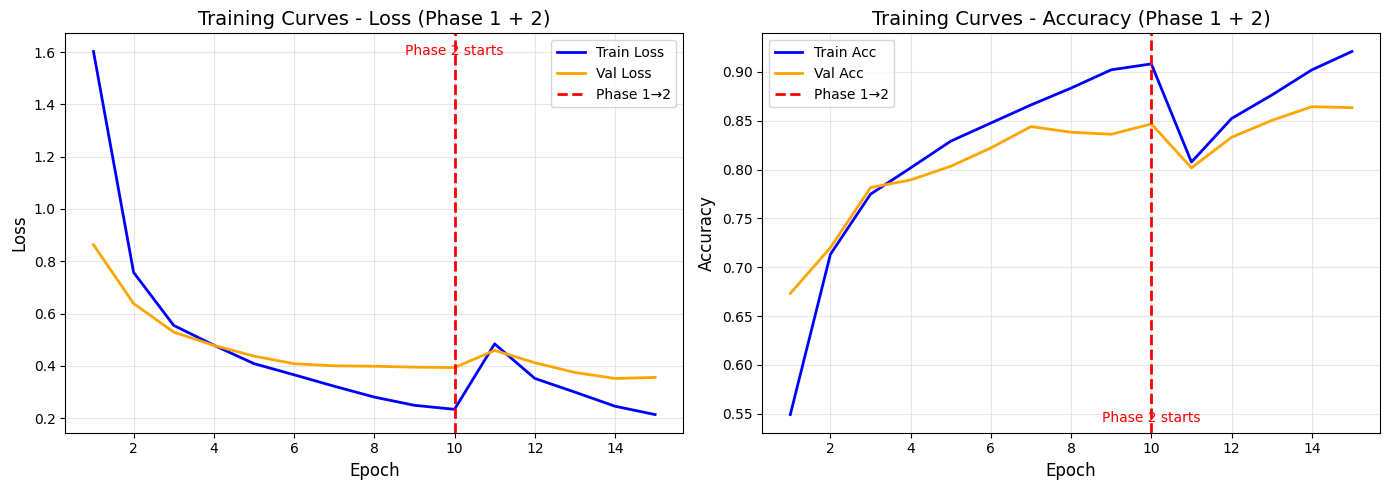

In [22]:
# ===============================
# CONFIGURATION
# ===============================
MODE = "train_p2"  # Options: "train_p1", "train_p2"
RESUME = False
EPOCHS = 5

# ===============================
# TRAINING FUNCTION (Used by both phases)
# ===============================
def train_phase(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs,
    start_epoch,
    phase,
    patience=5,
    initial_best_acc=0.0
):
    """
    Generic training function for any phase
    """
    best_val_acc = initial_best_acc
    patience_counter = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(start_epoch + 1, num_epochs + 1):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)

        # Validate
        val_loss, val_acc = eval_epoch(model, val_loader)

        # Track metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print progress
        print(f"[P{phase}][Epoch {epoch}/{num_epochs}] "
              f"Train: {train_acc:.4f} | Val: {val_acc:.4f}")

        # Save checkpoint
        save_checkpoint(model, optimizer, scheduler, epoch, phase, val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_path = os.path.join(CHECKPOINT_DIR, f"best_model_p{phase}.pt")
            torch.save(model.state_dict(), best_path)
            print(f"   New best: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   Early stopping at epoch {epoch}")
                break

    return history


# ===============================
# PHASE 1
# ===============================
if MODE == "train_p1":
    print("="*60)
    print("PHASE 1: Fine-tune last 3 transformer blocks")
    print("="*60)

    # Setup model
    freeze_all_clip(clip_model)
    unfreeze_last_blocks(clip_model, num_blocks=3)

    # Optimizer
    base_lr = 2e-4
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=base_lr,
        weight_decay=1e-4
    )

    # Load checkpoint if resuming
    start_epoch = 0
    best_val_acc = 0.0

    if RESUME:
        temp_scheduler = CosineAnnealingLR(optimizer, T_max=1, eta_min=base_lr*0.01)
        start_epoch, best_val_acc = load_checkpoint(model, optimizer, temp_scheduler, phase=1)

    # Scheduler
    num_epochs = start_epoch + EPOCHS
    remaining_steps = (num_epochs - start_epoch) * len(train_loader)
    scheduler = CosineAnnealingLR(optimizer, T_max=remaining_steps, eta_min=base_lr*0.01)

    if RESUME:
        scheduler.load_state_dict(temp_scheduler.state_dict())

    # Train
    history = train_phase(
        model, train_loader, val_loader, optimizer, scheduler,
        num_epochs=num_epochs,
        start_epoch=start_epoch,
        phase=1,
        patience=5,
        initial_best_acc=best_val_acc
    )


    # Save Phase 1 history

    with open(os.path.join(CHECKPOINT_DIR, "phase1_history.pkl"), "wb") as f:
        pickle.dump(history, f)

    print(f"\n Phase 1 complete! Best val acc: {max(history['val_acc']):.4f}\n")

# ===============================
# PHASE 2
# ===============================
elif MODE == "train_p2":
    print("="*60)
    print("PHASE 2: Fine-tune full text encoder + 6 vision blocks")
    print("="*60)

    # Load checkpoint if resuming Phase 2
    start_epoch = 0
    best_val_acc = 0.0

    # Load Phase 1 weights
    if not RESUME:
        best_p1_path = os.path.join(CHECKPOINT_DIR, "best_model_p1.pt")
        if os.path.exists(best_p1_path):
            print(" Loading best Phase 1 model...")
            model.load_state_dict(torch.load(best_p1_path))
        else:
            print(" Best P1 not found, loading checkpoint...")
            load_checkpoint(model, phase=1)

    # Setup model
    unfreeze_last_blocks(clip_model, num_blocks=6)
    unfreeze_full_text_encoder(clip_model)

    # Optimizer (fresh for Phase 2)
    base_lr = 5e-5
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=base_lr,
        weight_decay=1e-4
    )



    if RESUME:
        temp_scheduler = CosineAnnealingLR(optimizer, T_max=1, eta_min=base_lr*0.01)
        start_epoch, best_val_acc = load_checkpoint(model, optimizer, temp_scheduler, phase=2)

    # Scheduler
    num_epochs = start_epoch + EPOCHS
    remaining_steps = (num_epochs - start_epoch) * len(train_loader)
    scheduler = CosineAnnealingLR(optimizer, T_max=remaining_steps, eta_min=base_lr*0.01)

    if RESUME:
        scheduler.load_state_dict(temp_scheduler.state_dict())

    # Train
    history_p2 = train_phase(
        model, train_loader, val_loader, optimizer, scheduler,
        num_epochs=num_epochs,
        start_epoch=start_epoch,
        phase=2,
        patience=5,
        initial_best_acc=best_val_acc
    )

    print(f"\n Phase 2 complete! Best val acc: {max(history_p2['val_acc']):.4f}\n")

    # Load Phase 1 history

    p1_history_path = os.path.join(CHECKPOINT_DIR, "phase1_history.pkl")

    if os.path.exists(p1_history_path):
        with open(p1_history_path, "rb") as f:
            history_p1 = pickle.load(f)

        # Combine histories
        combined_history = {
            "train_loss": history_p1["train_loss"] + history_p2["train_loss"],
            "train_acc": history_p1["train_acc"] + history_p2["train_acc"],
            "val_loss": history_p1["val_loss"] + history_p2["val_loss"],
            "val_acc": history_p1["val_acc"] + history_p2["val_acc"],
            "p1_epochs": len(history_p1["train_loss"])  # Mark where P1 ends
        }

        # Plot combined
        plot_combined_training(combined_history)
    else:
        print(" Phase 1 history not found, plotting Phase 2 only")




In [26]:
# ===============================
# EVALUATION
# ===============================

print("="*60)
print("EVALUATION")
print("="*60)

# Load best Phase 2 model
best_p2_path = os.path.join(CHECKPOINT_DIR, "best_model_p2.pt")
if os.path.exists(best_p2_path):
    print(" Loading best Phase 2 model...")
    model.load_state_dict(torch.load(best_p2_path))
else:
    print(" Loading Phase 2 checkpoint...")
    load_checkpoint(model, phase=2)

# Test accuracy
test_loss, test_acc = eval_epoch(model, test_loader)
print(f"\n Test Accuracy: {test_acc:.4f}")

# F1 scores
results = eval_f1_by_type(model, test_loader, device)
print("\n F1 Scores:")
print(f"  All questions : {results['all_f1']:.4f}")
print(f"  Open-ended    : {results['open_f1']:.4f}")
print(f"  Closed-ended  : {results['closed_f1']:.4f}")

print("\n Evaluation complete!")

EVALUATION
 Loading best Phase 2 model...

 Test Accuracy: 0.8603

 F1 Scores:
  All questions : 0.7353
  Open-ended    : 0.7271
  Closed-ended  : 0.7974

 Evaluation complete!


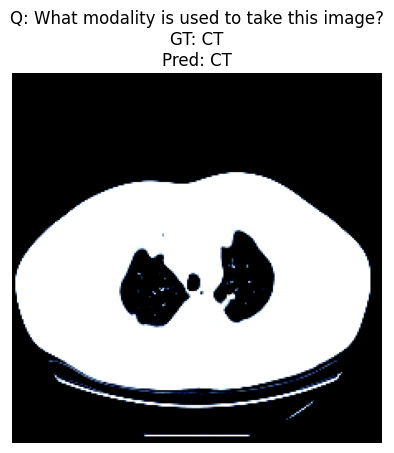

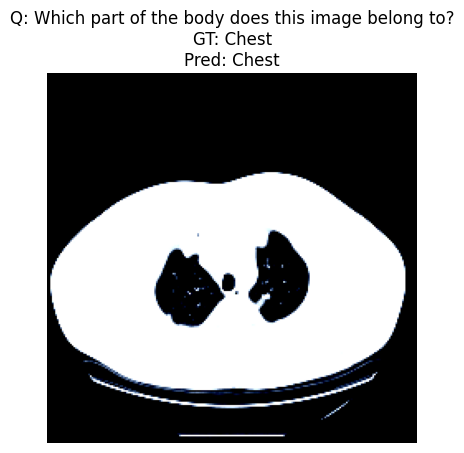

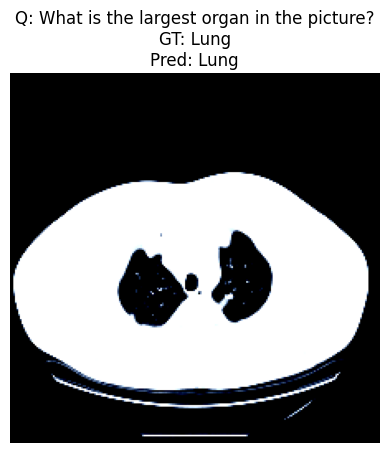

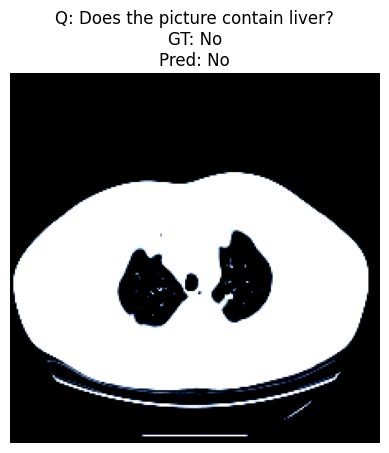

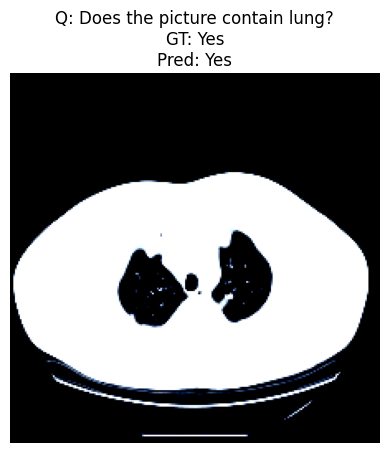

In [27]:
def show_qualitative_examples(model, dataset, idx2answer, n=5):
    model.eval()
    for i in range(n):
        sample = dataset[i]
        image = sample["image"].unsqueeze(0).to(device)
        question = sample["question_input"].unsqueeze(0).to(device)
        label = sample['label'].item()

        with torch.no_grad():
            pred = model(image, question).argmax(dim=1).item()

        plt.imshow(sample["image"].permute(1,2,0))
        plt.axis("off")
        plt.title(
            f"Q: {dataset.data[i][1]}\n"
            f"GT: {idx2answer[label]}\n"
            f"Pred: {idx2answer[pred]}"
        )
        plt.show()

show_qualitative_examples(model, test_dataset_clip, idx2answer)